# Age Verification Model for Ensuring Compliance in Retail

### Table of Contents

* [Computer Vision](#scrollTo=g8raAq0b8iUl)
    * [1. Initialization](#scrollTo=_mGsGyTb8iUn)
    * [2. Data Preparation](#scrollTo=98dcmXlG8iUv)
    * [3. EDA](#scrollTo=-BMWMDGA8iVA)
    * [4. Modelling](#scrollTo=YV678Kvo8iVU)
        * [4.1. Set up Scripts to run on GPU platforms](#scrollTo=3dqbVPSX8iVp)
        * [4.2. Output](#scrollTo=MiPmhhBj8iVx)
    * [Conclusion](#scrollTo=NPIY3er98iV4)



# Computer Vision

Good Seed, a supermarket chain, wants to know if Data Science can help them comply with the law by ensuring they do not sell age-restricted products to underage customers. You've been asked to do the evaluation, so when you get to work, keep the following in mind:

- The stores are equipped with cameras in the checkout area that will display a signal when someone buys an age-restricted product
- Computer vision methods can be used to determine a person's age from photos
- The next task is to build and evaluate a model to verify a person's age

To start working on this task, you will get photos of people with their age captions.

## 1. Initialization 

In [ ]:
# import the required libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('default')

## 2. Data Preparation

The *dataset* is stored in the folder `/datasets/faces/`, which you can find - The folder `final_file` with 7.6k photos 
- A `labels.csv` file with labels, with two columns: `file_name` and `real_age` 

Considering that the number of image files is quite large, it is better to avoid reading all of them at once, as it will consume a lot of computing resources. We took the initiative to create a generator with ImageDataGenerator. This method has been explained previously in Chapter 3, Lesson 7. 

The file label can be loaded as a normal CSV file.

In [ ]:
# data directory
data_root_path = '/datasets/faces/'

In [ ]:
# labels of the data location
labels = pd.read_csv('/datasets/faces/labels.csv')

In [ ]:
# print the information of the labels
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
# print the sample of labels
labels.sample(5)

file_name  real_age
468   000468.jpg        19
5151  005151.jpg        30
3590  003590.jpg        14
1466  001466.jpg        47
752   000752.jpg        14

In [ ]:
# print the statistic descritive of the labels
labels.describe(percentiles=[.1, .05, .25, .75, .95, .99]).round(1).T

count  mean   std  min   5%   10%   25%   50%   75%   95%   99%  \
real_age  7591.0  31.2  17.1  1.0  5.0  12.0  20.0  29.0  41.0  63.0  82.0   

            max  
real_age  100.0

**Findings:** 
- For `real_age`, there are no anomalous or missing values, thus no correction is necessary.


- Data augmentation or layer freezing may be necessary when the dataset is not particularly vast for a NN model.

In [ ]:
# create a function to load the data and return it in a variable

def create_gen_flow(min_age=0, max_age=100):
    
    datagen = ImageDataGenerator(rescale=1./255) # Set the pixel value in the range [0,1]
    
    gen_flow = datagen.flow_from_dataframe(
        dataframe=labels.query('real_age >= @min_age and real_age <= @max_age'),
        directory='/datasets/faces/final_files',
        x_col='file_name', 
        y_col='real_age',
        target_size=(240, 240),
        batch_size=16, 
        class_mode='raw',
        seed=12345)
    
    return gen_flow

## 3. EDA

In [ ]:
# count of distinct age values with 0 for missing ages

dft1 = labels['real_age'].value_counts().sort_index().reindex(np.arange(0, 101)).fillna(0).astype('int')
dft1

0        0
1      149
2       88
3       25
4      101
      ... 
96       2
97       1
98       0
99       0
100      1
Name: real_age, Length: 101, dtype: int64

In [ ]:
# the same as above by groupped by range 

dft2 = pd.cut(labels['real_age'], np.arange(0, 101, 10), right=False).value_counts().sort_index()
dft2 

[0, 10)       663
[10, 20)     1213
[20, 30)     2075
[30, 40)     1564
[40, 50)      940
[50, 60)      615
[60, 70)      279
[70, 80)      130
[80, 90)       78
[90, 100)      33
Name: real_age, dtype: int64

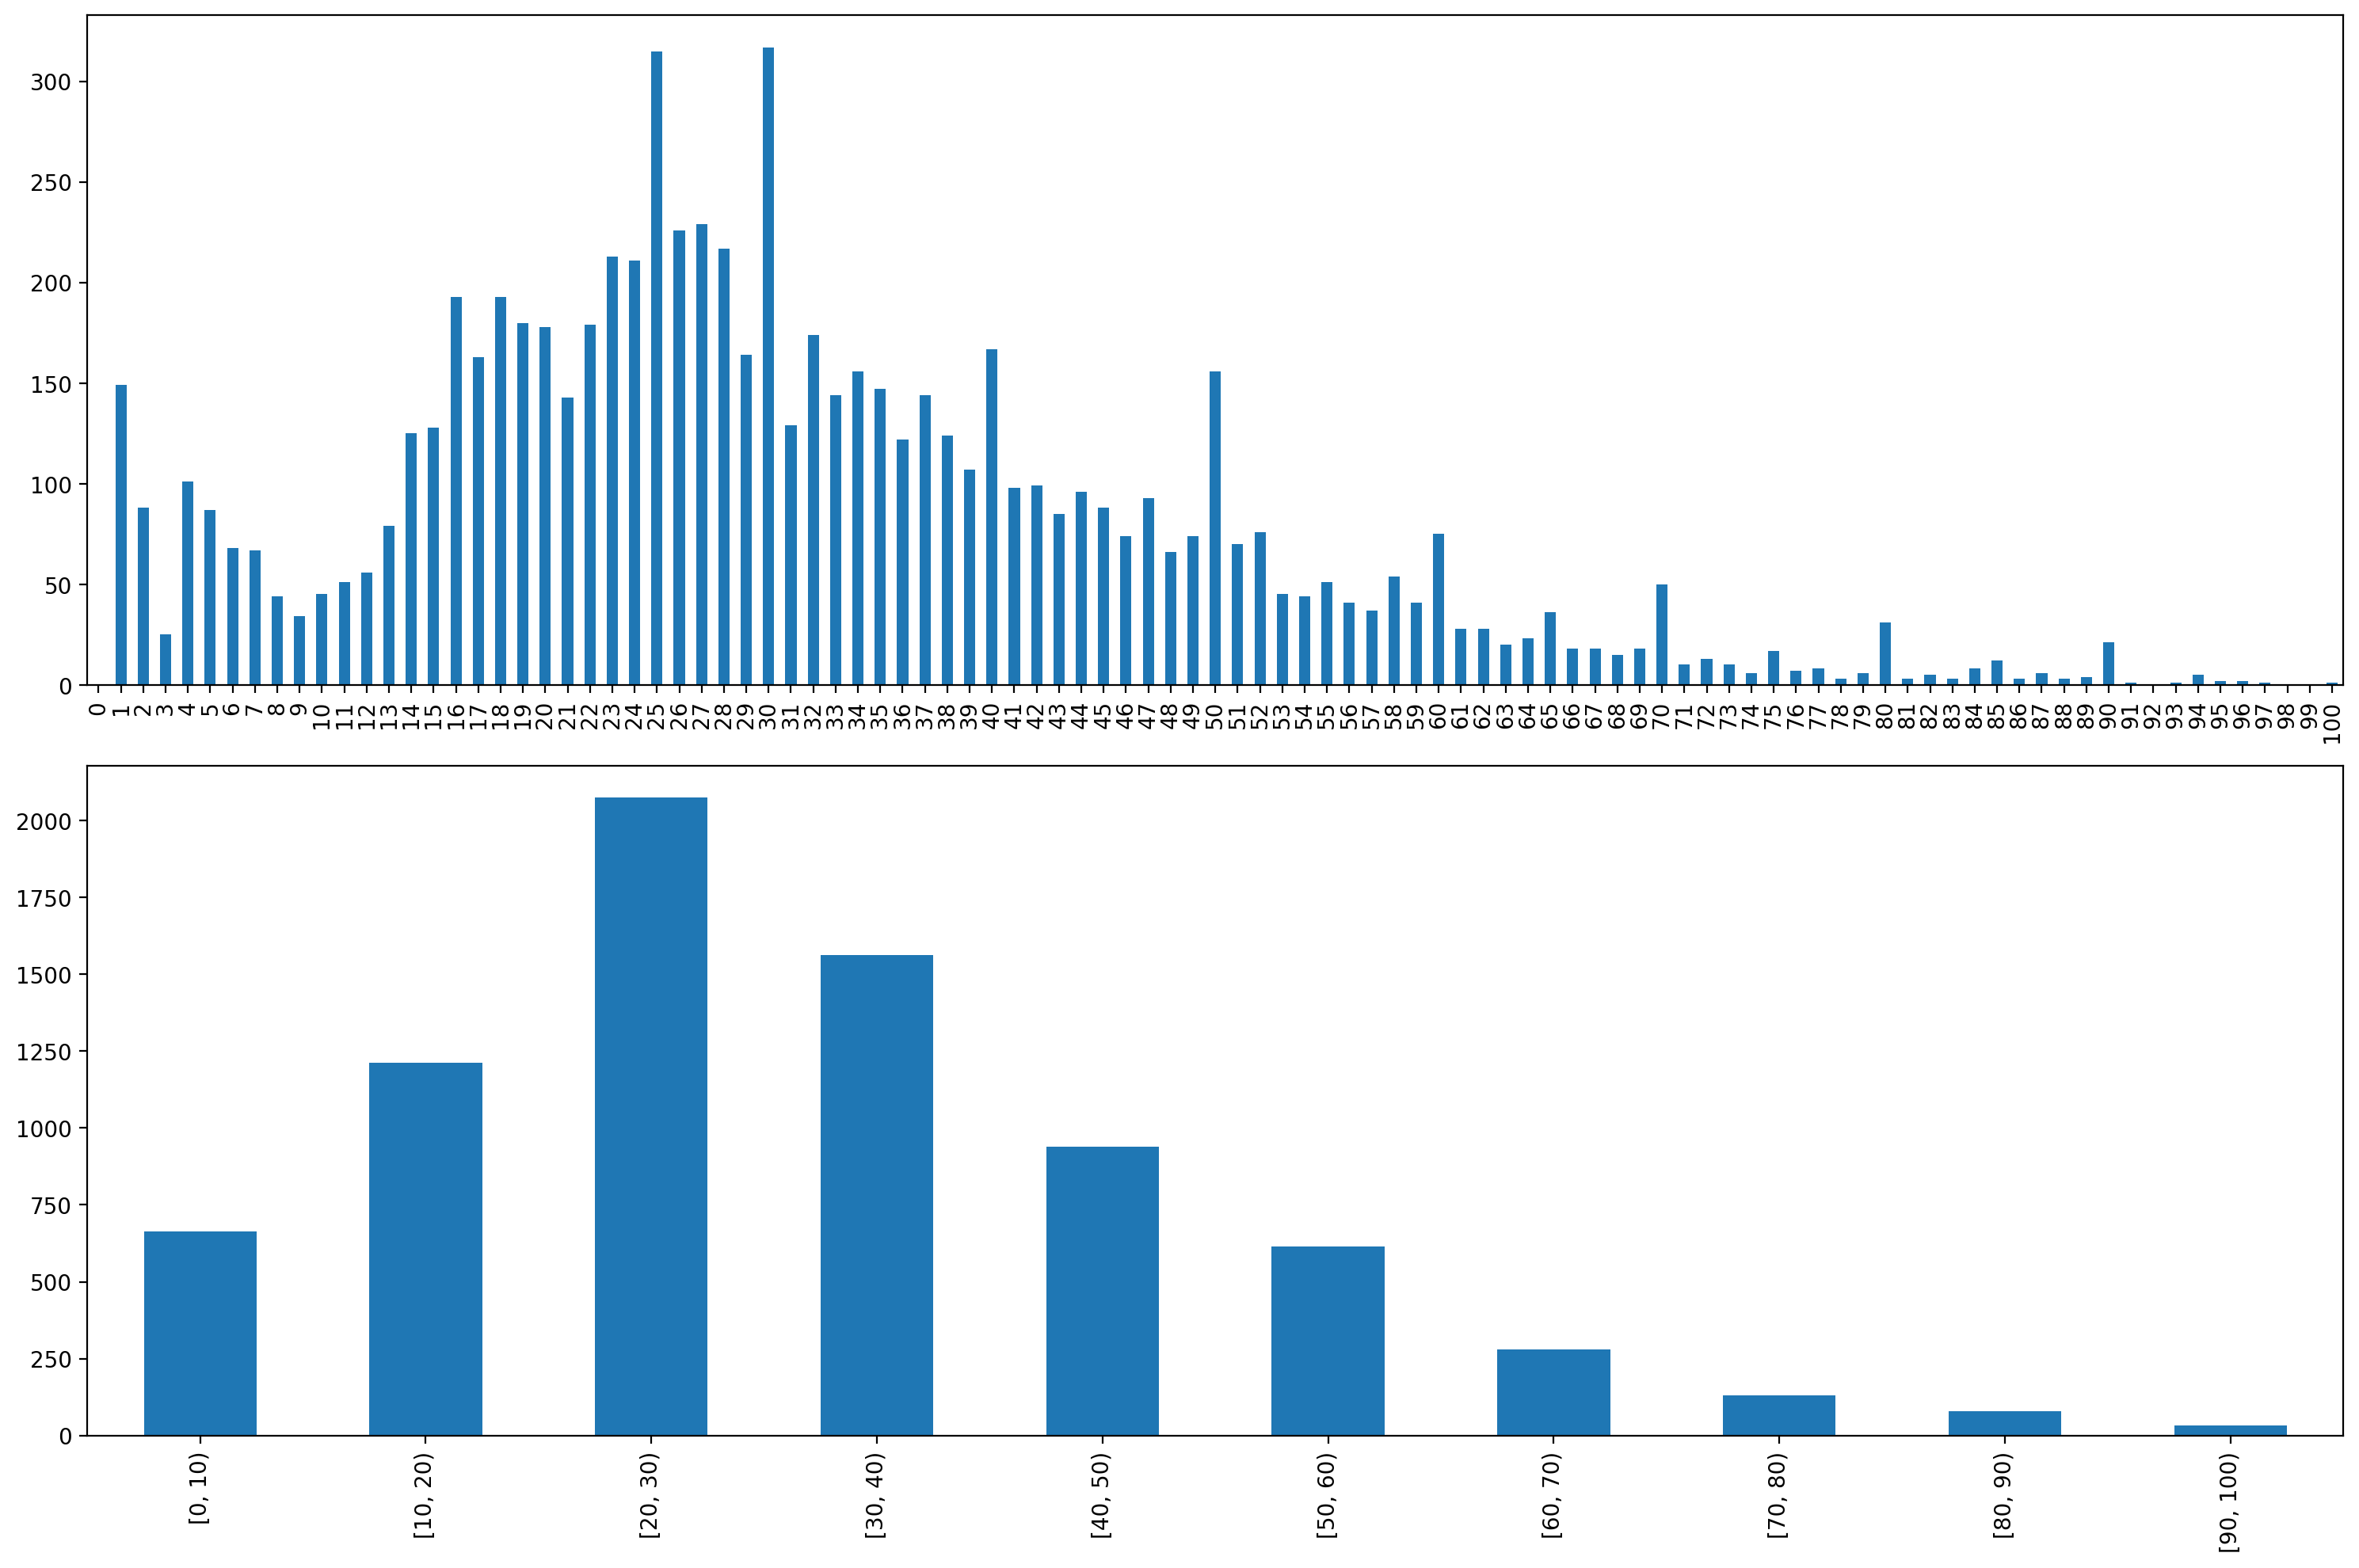

In [ ]:
# displays the age distribution of the dataset

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

ax = axs[0]
dft1.plot(kind='bar', ax=ax)

ax = axs[1]
dft2.plot(kind='bar', ax=ax)

fig.tight_layout()

**Findings:** 

1. The sample has few senior citizens. Due to the lack of examples, the model might not be properly trained for these ages. At the same time, the magnitude of the error there can be rather large: it is probably harder to distinguish between 80 and 90 years than between 0 and 10. 


2. Several age values have a large number of counts associated with them. Are those to be regarded as anomalies? Most likely, as some of the dataset's participants had ages that were estimated based on normal values because their true ages were unknown. In order to avoid confusing the model, it could be worthwhile to utilize examples with real_age large counts.


3. The histogram shows 2-4 clusters. (depending on how you look). Perhaps this means that they were combined from many sources; for instance, one source may have dealt with children under 10, and another with adults above 10. Perhaps different preprocessing is required for images from different sources. (it could turn out that only people over 10 have black and white pictures, or that children have wrong orientations of the picture).


4. To clarify some of the conclusions above, it is worthwhile to examine a few random photographs.

In [ ]:
# create a function to display sample images

def show_batch(batch, predictions=None):
    
    rows = 3
    cols = 5
    fig, axs = plt.subplots(rows, cols, figsize=(10, 6))

    for i in range(15):
        
        # fig.add_subplot(3, 5, i+1)
        row = i // cols
        col = i % cols
        ax = axs[row][col]
        ax.imshow(batch[0][i])
        real_age = batch[1][i]
        if predictions is None:
            title = f'age: {real_age}'
        else:
            title = f'age: {real_age}, pred: {round(predictions[i])}'
        ax.set_title(title, fontsize='medium')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    fig.tight_layout()

In [ ]:
# insert the function into the variable

gen_flow_0_9 = create_gen_flow(min_age=0, max_age=9)
gen_flow_10_79 = create_gen_flow(min_age=10, max_age=79)
gen_flow_80_100 = create_gen_flow(min_age=81, max_age=100)

Found 663 validated image filenames.
Found 6816 validated image filenames.
Found 81 validated image filenames.


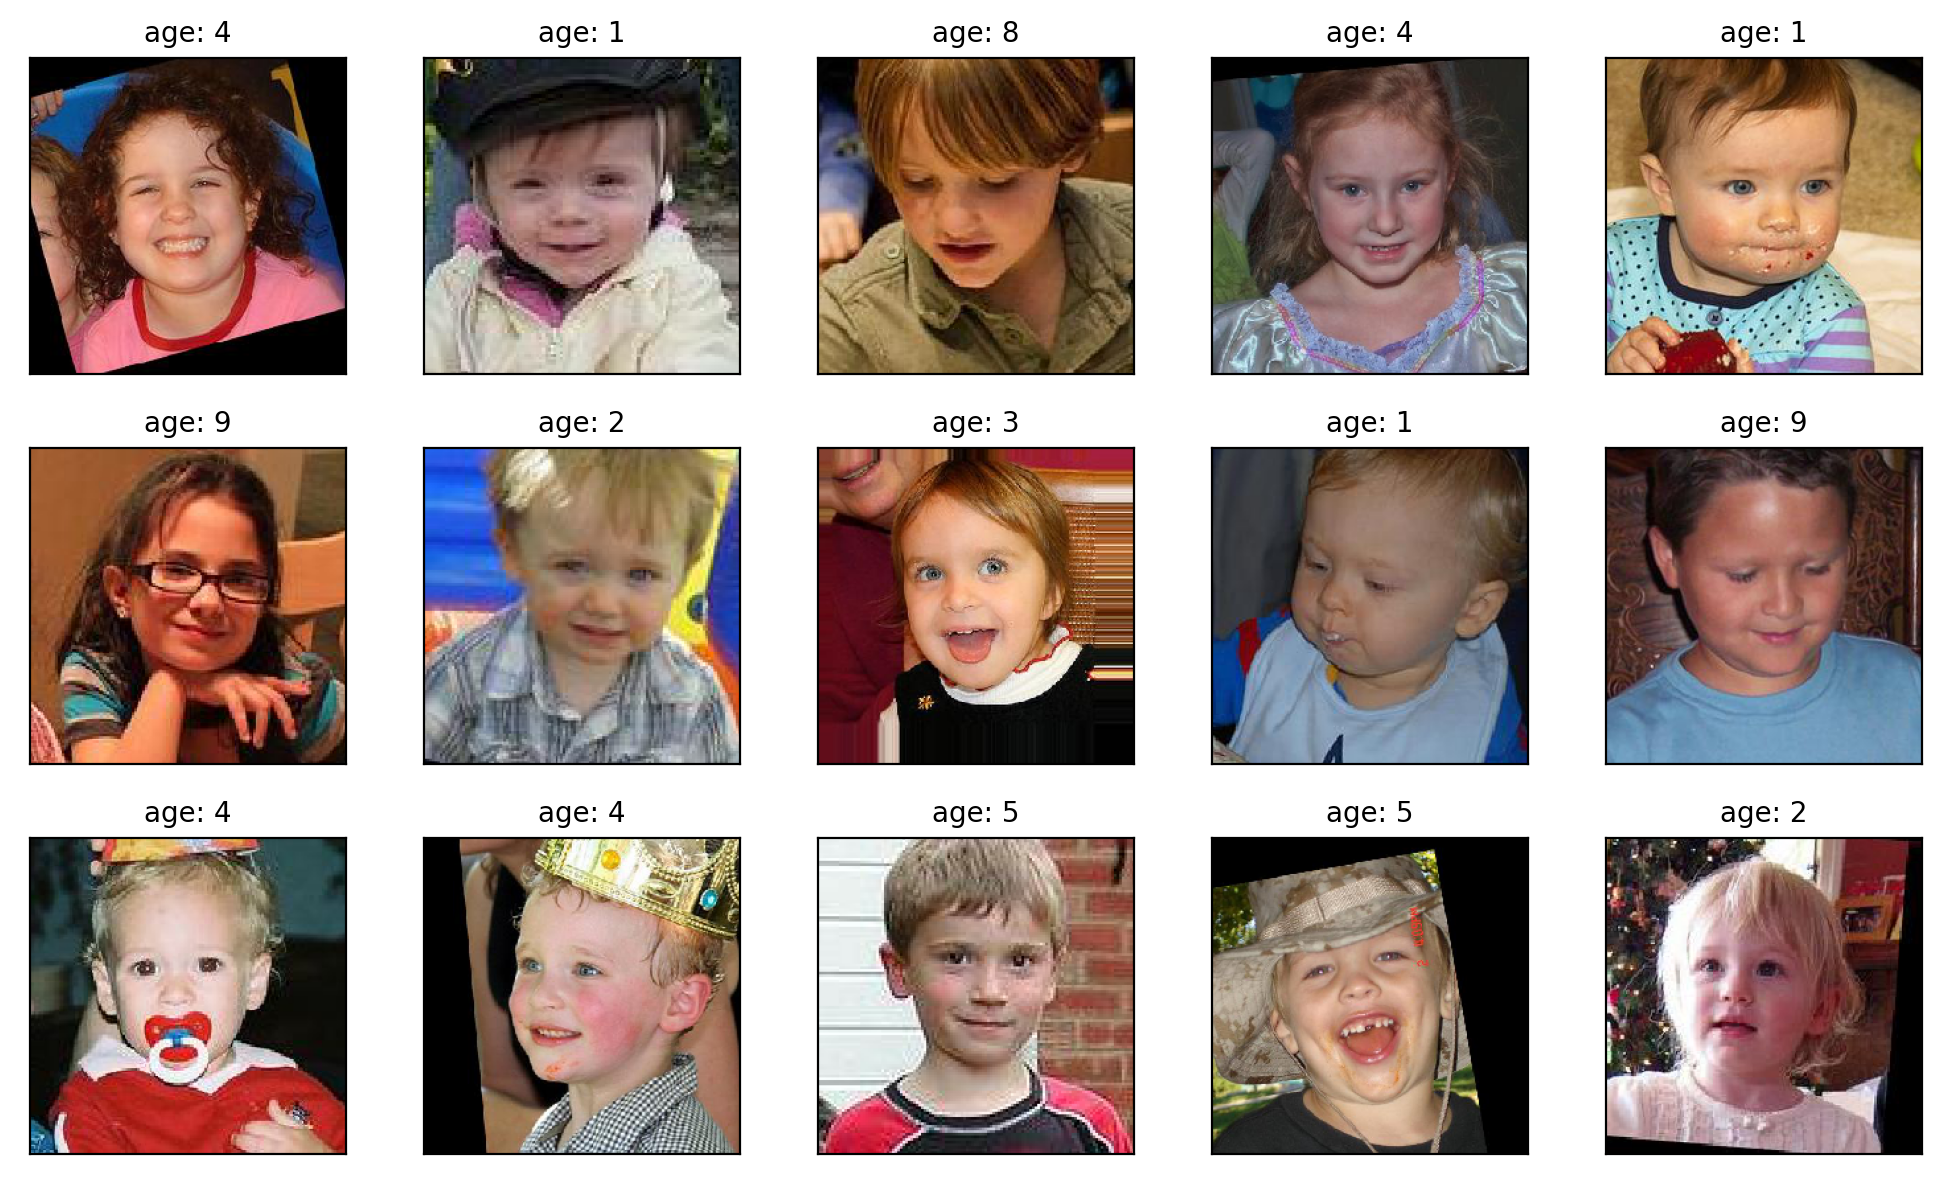

In [ ]:
# display sample images of ages 0-9
show_batch(next(gen_flow_0_9))

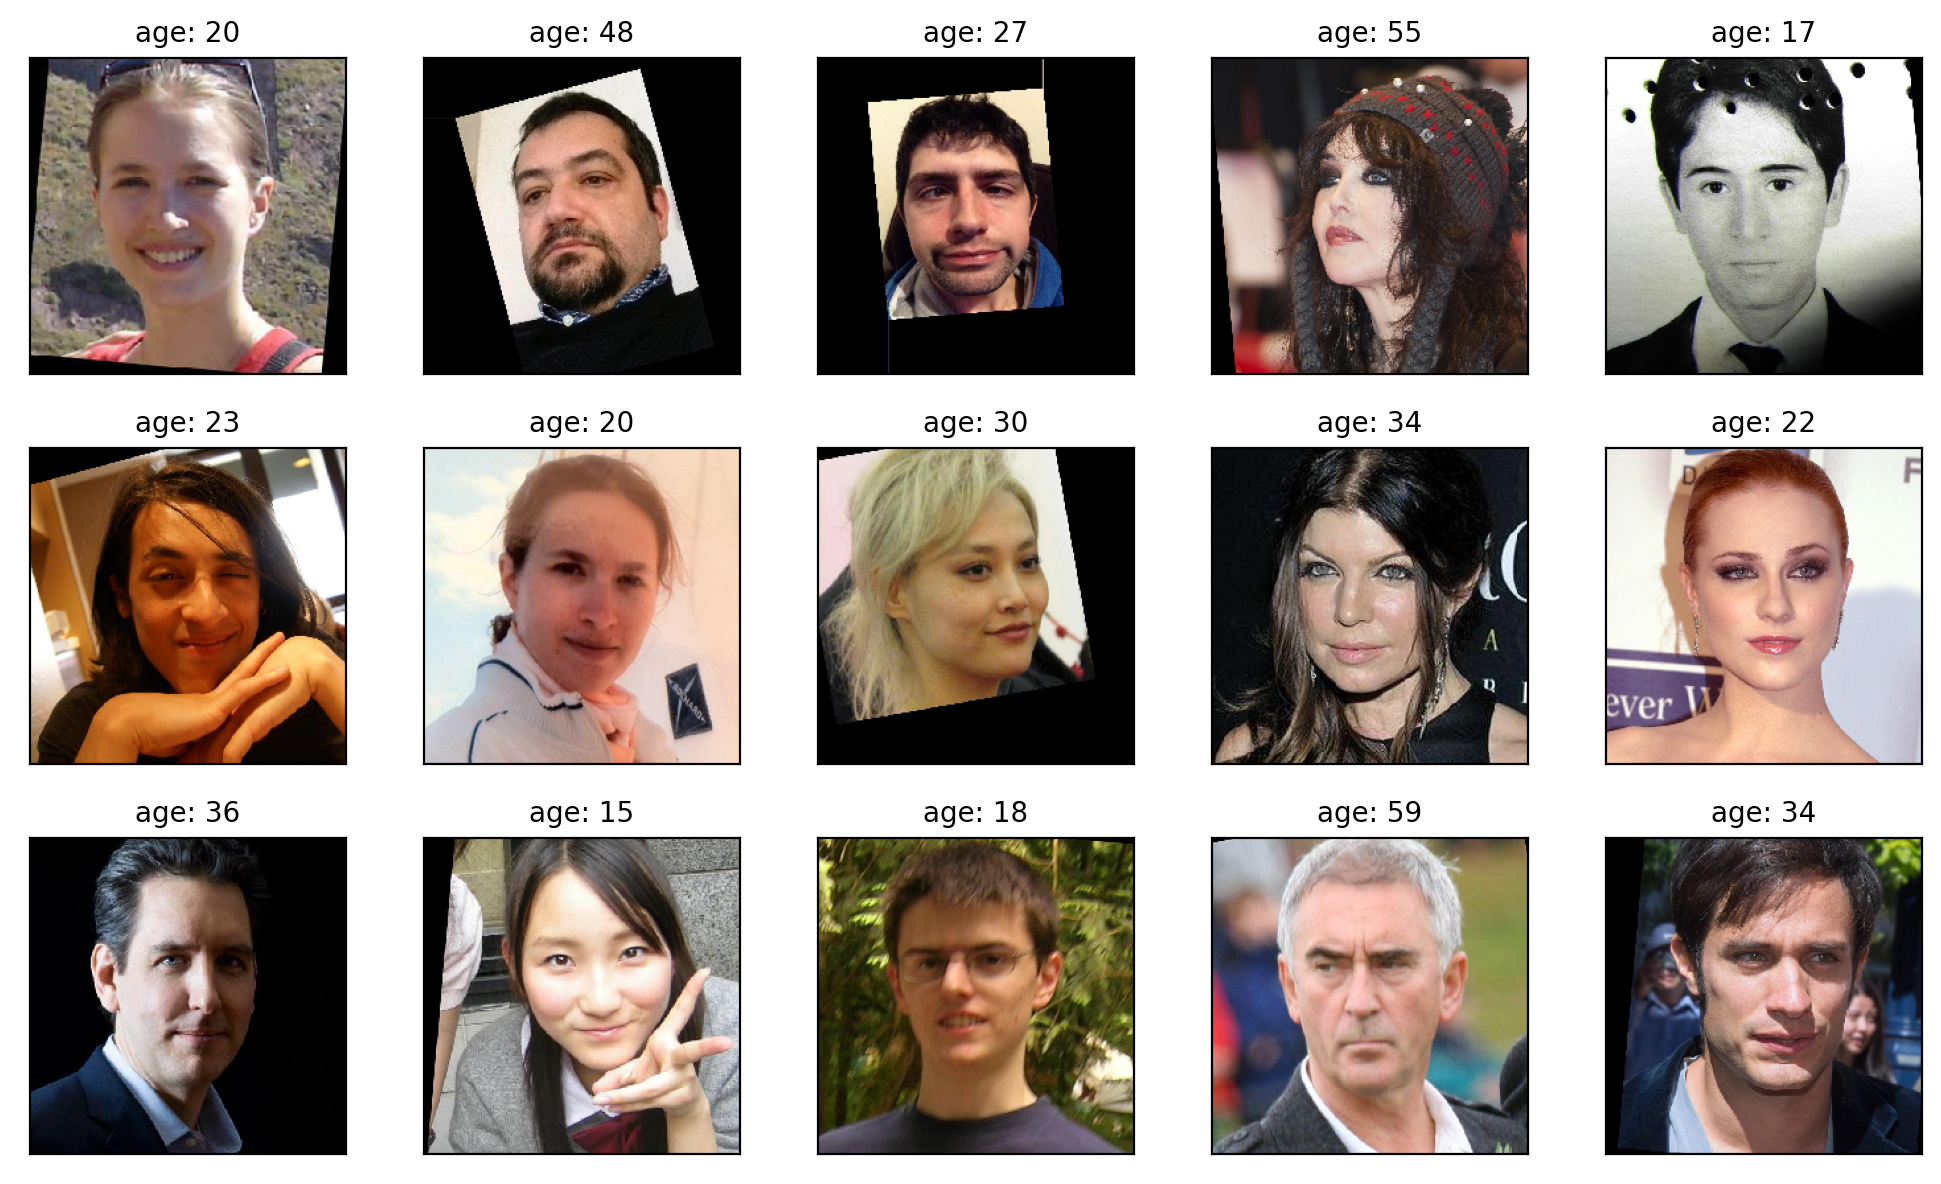

In [ ]:
# display sample images of ages 10-79
show_batch(next(gen_flow_10_79))

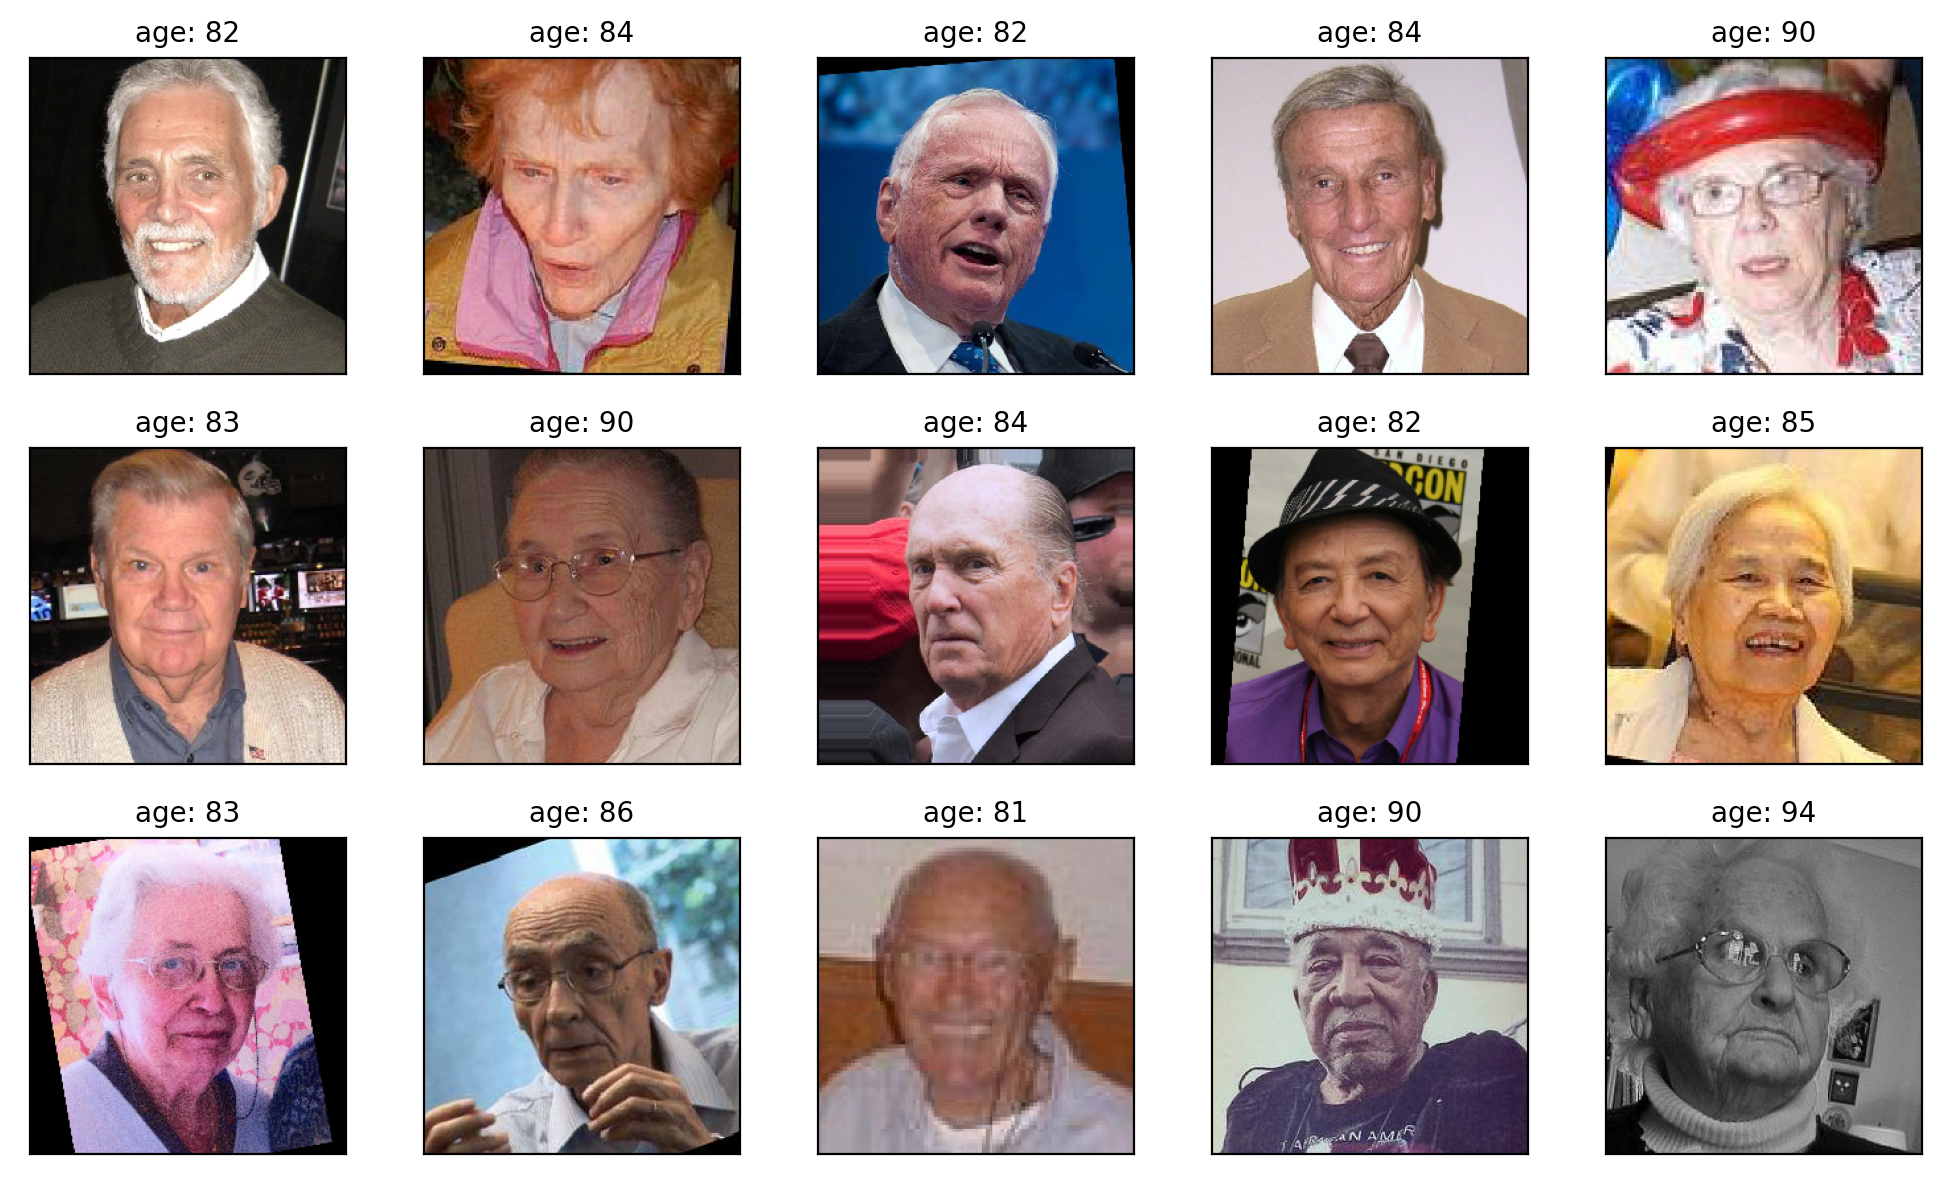

In [ ]:
# display sample images of ages 80-100
show_batch(next(gen_flow_80_100))

**Findings:** 
    
1. The photos are already oriented properly. Some of the images look like they were recreated from physical photos.


2. Due to the pre-trained model's reliance on ImageNet for training, all photographs were forced to be 224x224 in size. (images of 224x224).


3. The dataset includes images of varying quality, including vintage, black and white, and colorful images. In a specific proportion of instances, doing augmentation to turn the image black and white makes sense. (not available in the standard set). It could be worthwhile to provide color shade and brightness enhancement (both included in the standard set).


4. The dataset contains different-sized faces; hence, the image may require zoom enhancement. It is unquestionably best to use `horizontal_flip` rather than `vertical_flip`.


## 4. Modelling 

Define the functions required to train our model on a GPU platform and create a single script containing all these functions along with an initialization section.

To make this task easier, we can define them in this *notebook* and run the ready-made code in the next section to build the script automatically.

In [ ]:
# import libraries for image processing

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [ ]:
# check gpu availability

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 8)])
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

logical_gpus = tf.config.list_logical_devices('GPU')        
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")  

0 Physical GPUs, 0 Logical GPUs


2023-04-10 22:28:07.226782: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# create a function to load the training set and return it in a variable

def load_train(path):
    
    """
    Ini memuat bagian *train* *dataset* dari jalur
    """
    
    # letakkan kode Anda di sini
    labels = pd.read_csv(path+'labels.csv')                                                     
    train_datagen = ImageDataGenerator(rescale= 1/255, validation_split=0.25, horizontal_flip=True)  
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42)

    return train_datagen_flow

In [ ]:
# create a function to load the test set and return it in a variable

def load_test(path):
    
    """
    Ini memuat *dataset* *validation/test* dari jalur
    """
    
    # letakkan kode Anda di sini
    labels = pd.read_csv(path+'labels.csv')                                                     
    train_datagen = ImageDataGenerator(rescale= 1/255, validation_split=0.25)  
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    return train_datagen_flow

In [ ]:
# create a function to set the model

def create_model(input_shape):
    
    """
    Ini menentukan modelnya
    """
    
    # letakkan kode Anda di sini
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential() # sequential model
    model.add(backbone)
    model.add(GlobalAveragePooling2D()) # GlobalAveragePooling2D architecture
    model.add(Dense(units=16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activity_regularizer=regularizers.l2(0.01), activation='relu'))

    optimizer = Adam(lr=0.0001) # using adam optimizer
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

In [ ]:
# create the function to train the model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    """
    Latih model dengan parameter yang diberikan
    """
    
    # letakkan kode Anda di sini
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

In [ ]:
# print model summary
model = create_model((150, 150, 3))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                32784     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 23,620,513
Trainable params: 23,567,393
Non-trainable params: 53,120
_______________________________________

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


- ResNets can help maintain low error rates much deeper into the network. This architecture is also among the most efficient.


- Dropout will ignore several randomly selected neurons, the effect of which is that the network becomes less sensitive to neuron-specific weights. Ultimately, this results in a network that is capable of better generalization.

### 4.1. Set up Scripts to run on GPU platforms

After determining the required functions, we can create a script for the GPU platform, download it via the "File|Open..." menu, and upload it later to run on the GPU platform. "

Notes: The script should include an initialization section as well. An example is shown below.

In [ ]:
# siapkan skrip untuk menjalankan platform GPU


init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

In [ ]:
# load the dataset

train_data = load_train('/datasets/faces/')
test_data = load_test('/datasets/faces/')
model = create_model((150, 150, 3))

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [ ]:
%%time

# train the model
model = train_model(model, train_data, test_data)

Epoch 1/5


### 4.2. Output

**Place the *output* of the GPU platform as a *Markdown* cell here.**

2023-04-10 06:58:21.334919: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6

2023-04-10 06:58:21.336527: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.

Found 5694 validated image filenames.

Found 1897 validated image filenames.

2023-04-10 06:58:22.351797: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1

2023-04-10 06:58:22.396786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-04-10 06:58:22.396985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0

coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s

2023-04-10 06:58:22.397020: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2023-04-10 06:58:22.397053: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-04-10 06:58:22.399111: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10

2023-04-10 06:58:22.399454: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10

2023-04-10 06:58:22.401603: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10

2023-04-10 06:58:22.402806: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10

2023-04-10 06:58:22.402861: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

2023-04-10 06:58:22.402936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-04-10 06:58:22.403163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-04-10 06:58:22.403314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0

2023-04-10 06:58:22.403640: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA

2023-04-10 06:58:22.410546: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300010000 Hz

2023-04-10 06:58:22.411139: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x459df60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:

2023-04-10 06:58:22.411163: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version

2023-04-10 06:58:22.498667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-04-10 06:58:22.498965: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x30807c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:

2023-04-10 06:58:22.498990: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0

2023-04-10 06:58:22.499258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-04-10 06:58:22.499498: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s

2023-04-10 06:58:22.499549: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2023-04-10 06:58:22.499573: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-04-10 06:58:22.499671: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10

2023-04-10 06:58:22.499698: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10

2023-04-10 06:58:22.499719: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

2023-04-10 06:58:22.499612: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10

2023-04-10 06:58:22.499642: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10

2023-04-10 06:58:22.768858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 

2023-04-10 06:58:22.768872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 

2023-04-10 06:58:22.768801: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:

2023-04-10 06:58:22.769693: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.

2023-04-10 06:58:22.769741: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14988 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-16GB, pci 
bus id: 0000:00:1e.0, compute capability: 7.0)

2023-04-10 06:58:22.499816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS 
had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-04-10 06:58:22.500352: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

2023-04-10 06:58:22.500099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-04-10 06:58:22.500298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0

2023-04-10 06:58:22.769471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-04-10 06:58:22.769152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5


8192/94765736 [..............................] - ETA: 1s

12804096/94765736 [===>..........................] - ETA: 0s

26451968/94765736 [=======>......................] - ETA: 0s

40255488/94765736 [===========>..................] - ETA: 0s

54018048/94765736 [================>.............] - ETA: 0s

67788800/94765736 [====================>.........] - ETA: 0s

81543168/94765736 [========================>.....] - ETA: 0s

94773248/94765736 [==============================] - 0s 0us/step

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']

Train for 356 steps, validate for 119 steps

Epoch 1/10

2023-04-10 06:58:33.513138: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-04-10 06:58:33.754698: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

356/356 - 47s - loss: 255.3507 - mae: 11.6373 - val_loss: 585.8687 - val_mae: 19.1213


Epoch 2/10

356/356 - 38s - loss: 155.7798 - mae: 8.9813 - val_loss: 154.9217 - val_mae: 8.9189

Epoch 3/10

356/356 - 38s - loss: 131.3428 - mae: 8.1675 - val_loss: 98.5492 - val_mae: 7.1909

Epoch 4/10

356/356 - 38s - loss: 116.8666 - mae: 7.6532 - val_loss: 132.2198 - val_mae: 8.3584

Epoch 5/10

356/356 - 38s - loss: 109.7769 - mae: 7.4441 - val_loss: 94.6387 - val_mae: 6.8744

Epoch 6/10

356/356 - 38s - loss: 100.7758 - mae: 7.0348 - val_loss: 102.3678 - val_mae: 7.2246

Epoch 7/10

356/356 - 38s - loss: 96.2768 - mae: 6.8203 - val_loss: 86.6083 - val_mae: 6.4151

Epoch 8/10

356/356 - 38s - loss: 90.6607 - mae: 6.6215 - val_loss: 154.7346 - val_mae: 9.2134

Epoch 9/10

356/356 - 38s - loss: 89.1671 - mae: 6.5093 - val_loss: 87.6021 - val_mae: 6.5096

Epoch 10/10

356/356 - 38s - loss: 91.7252 - mae: 6.6124 - val_loss: 86.6366 - val_mae: 6.4057

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']

119/119 - 9s - loss: 86.6366 - mae: 6.4057

Test MAE: 6.4057

**Findings**:
- Excellent results were achieved from our model where our model avoided overfitting.


- The MSE loss function worked effectively for training the model. We add the [`activity_regularizer`](https://analyticsindiamag.com/what-is-activity-regularization-in-neural-networks/) parameter to the dense layer to generalize unknown data while keeping the learning model simple.


- For improved convergence, the step in Adam has to be somewhat lowered. Layer freezing was not necessary; rather, augmentation was for increasing the amount of data by generating new data points from existing data.


-  The validation quality is rather erratic, but it is deteriorating over time. This could be as a result of the sample being rather tiny and diverse.


- It is difficult to achieve MAE close to zero, if possible at all. Indeed, it is difficult for people to determine age in many images, so, perhaps, there is simply not enough information in the photographs, and below a certain threshold the quality cannot be obtained.

## Conclusion

**1. Data Preprocessing**

- We have about 7.6k data or 7591 data in image format.


- We split the train and test data into a 75:25 ratio.

**2. EDA**

- Most images are in the age range of 10-50 years, while ages above 70 have a minimal number of images. It makes it difficult for the model to predict faces at an old age.

**3. Modeling**

- With ImageDataGenerator, in addition to homogenizing the different pixel sizes, this process is also helpful for reducing the image size to speed up the computation process.


- We used 5 layers in the model: ResNet, GlobalAveragePooling2D, Dropout, and Dense.


- The results achieved are very satisfying where our model has a very low **mae** (below 7), and most importantly, our model avoids overfitting. By setting the value of **epoch = 5**, we recorded a short training time and made the model computationally efficient.